## NLP Project 박연주 / 손정민

#### Requirements 설치 및 dataset 다운로드를 위한 버전 맞추기

In [1]:
!pip install transformers datasets sentencepiece accelerate evaluate sacrebleu nltk protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [evaluate]5/7 [datasets]e]


In [2]:
!pip install fsspec==2023.9.2 datasets==2.19.1 huggingface_hub==0.21.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.29.3
    Uninstalling huggingface-hub-0.29.3:
      Successfully uninstalled huggingface-hub-0.29.3
  Attempting uninstall: datasets╺━━━━━━━━━━━━━━━━━━━ 2/4 [huggingface_hub]
    Found existing installation: datasets 3.6.0━━━━━━━━━━━━━━━ 2/4 [huggingface_hub]
    Uninstalling datasets-3.6.0:m╺━━━━━━━━━━━━━━━━━━━ 2/4 [huggingface_hub]
      Successfully uninstalled datasets-3.6.0━━━━━━━━━━━━━━━━━ 2/4 [huggingface_hub]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [datasets]3/4 [datasets]ub]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

In [3]:
import sys
print(sys.modules)

{'sys': <module 'sys' (built-in)>, 'builtins': <module 'builtins' (built-in)>, '_frozen_importlib': <module '_frozen_importlib' (frozen)>, '_imp': <module '_imp' (built-in)>, '_thread': <module '_thread' (built-in)>, '_warnings': <module '_warnings' (built-in)>, '_weakref': <module '_weakref' (built-in)>, '_io': <module '_io' (built-in)>, 'marshal': <module 'marshal' (built-in)>, 'posix': <module 'posix' (built-in)>, '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>, 'time': <module 'time' (built-in)>, 'zipimport': <module 'zipimport' (frozen)>, '_codecs': <module '_codecs' (built-in)>, 'codecs': <module 'codecs' (frozen)>, 'encodings.aliases': <module 'encodings.aliases' from '/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/encodings/aliases.py'>, 'encodings': <module 'encodings' from '/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/encodings/__init__.py'>, 'encodings.utf_8': <module 'encodings.utf_8' from '/Library/Framew

In [4]:
from datasets import load_dataset

en_ko = load_dataset("bongsoo/news_talk_en_ko")

ModuleNotFoundError: No module named 'datasets'

In [5]:
en_ko

DatasetDict({
    train: Dataset({
        features: ["Skinner's reward is mostly eye-watering.", '스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.'],
        num_rows: 1299999
    })
})

#### 데이터셋 구조 파악 및 column명을 제대로 붙이기 위한 수정 작업 진행

In [6]:
#데이터 구조 파악
print(en_ko)

print(en_ko["train"].column_names)

print(en_ko["train"].features)

print(en_ko["train"][1])


DatasetDict({
    train: Dataset({
        features: ["Skinner's reward is mostly eye-watering.", '스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.'],
        num_rows: 1299999
    })
})
["Skinner's reward is mostly eye-watering.", '스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.']
{"Skinner's reward is mostly eye-watering.": Value(dtype='string', id=None), '스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.': Value(dtype='string', id=None)}
{"Skinner's reward is mostly eye-watering.": 'Only God will exactly know why.', '스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.': '오직 하나님만이 그 이유를 제대로 알 수 있을 겁니다.'}


In [ ]:
from datasets import Dataset, concatenate_datasets

train_ds = en_ko["train"]

# 1. renaming the column into 'en' & 'ko'
train_ds = train_ds.rename_column("Skinner's reward is mostly eye-watering.", "en")
train_ds = train_ds.rename_column("스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.", "ko")

# 2. 데이터셋 재정의 (원래의 column명으로 쓰이던 문장 추가)
header_ds = Dataset.from_dict({
    "en": ["Skinner's reward is mostly eye-watering."],
    "ko": ["스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다."]
})

# 3. 원래 데이터셋이랑 합치기
train_ds = concatenate_datasets([header_ds, train_ds])

# 테스트
print(train_ds)
print(train_ds[3])

Dataset({
    features: ['en', 'ko'],
    num_rows: 1300000
})
{'en': "Businesses should not overlook China's dispute.", 'ko': '중국의 논쟁을 보며 간과해선 안 될 게 기업들의 고충이다.'}


#### 모델 설정 및 max token length 등 학습에 필요한 사항 정의


In [1]:
model_ckpt = "KETI-AIR/ke-t5-base"
max_token_length = 64

from transformers import AutoTokenizer

# T5 모델은 SentencePiece 기반 Tokenizer 사용
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
def preprocess_function(examples):
    # T5에 맞춰 prefix를 붙인 입력 문장 구성
    inputs = [f"translate Korean to English: {text}" for text in examples["ko"]]
    targets = examples["en"]
    
    # 인풋 토큰화
    model_inputs = tokenizer(
        inputs,
        max_length=max_token_length,
        truncation=True
    )
    
    # 타겟(정답) 문장 토큰화
    # 최신 버전을 사용하면 예시 docs처럼 한 번에 처리할 수 있다고는 하는데 이게 성능 면에서 나을 것 같아서 그냥 별도로 처리하기로 결정했습니다.
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_token_length,
            truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [10]:
tokenized_dataset = train_ds.map(
    preprocess_function,
    batched=True,
    # 기존 컬럼 'ko', 'en' 제거하여 메모리 사용량 줄이기
    remove_columns=["ko", "en"]
)

Map:   0%|          | 0/1300000 [00:00<?, ? examples/s]

/Users/aria/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [11]:
print(tokenized_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1300000
})


#### Data Shuffle 진행 및 hyperparameter 설정, Data load 및 모델 정의

In [12]:
# shuffle을 위해 정의
shuffled_dataset = tokenized_dataset.shuffle(seed=42).select(range(130000))

# 주어진 비율에 따라 train / validation / test로 추출 구분
train_dataset = shuffled_dataset.select(range(120000))
eval_dataset = shuffled_dataset.select(range(120000, 120000 + 9000))
test_dataset = shuffled_dataset.select(range(120000 + 9000, 120000 + 9000 + 1000))

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, get_scheduler
from accelerate import Accelerator
import numpy as np

# ========== 하이퍼파라미터 설정 ==========
num_epochs = 7
train_batch_size = 8
eval_batch_size = 4
learning_rate = 1e-4

In [14]:
def data_collator(batch, tokenizer):

    input_ids = [example["input_ids"] for example in batch]
    attention_masks = [example["attention_mask"] for example in batch]
    labels = [example["labels"] for example in batch]
    
    inputs = tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_masks},
        padding=True,
        return_tensors="pt"
    )
    
    label_pad = tokenizer.pad(
        {"input_ids": labels},
        padding=True,
        return_tensors="pt" #텐서 형태로 반환
    )

    inputs["labels"] = label_pad["input_ids"]
    
    return inputs

In [15]:
# DataLoader 생성, 위에서 정의한 data_collator 사용
train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=lambda batch: data_collator(batch, tokenizer)
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    collate_fn=lambda batch: data_collator(batch, tokenizer)
)

In [16]:
# 모델 로드
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# 학습 스케줄러
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/Users/aria/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [17]:
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

#### 모델 학습을 위해서 Colab을 사용
##### 아래 구간은 runtime을 고려하여 checkpoint를 생성 / 저장 / 저장된 구간부터 재학습을 하기 위한 colab용 코드입니다.
drive에 checkpoint 파일을 업로드하고, 파일 존재 여부 확인 후 해당 체크포인트에 저장된 모델을 로드하여 다시 학습을 이어나갈 수 있도록 하는 코드를 작성했습니다.
원래 최초 모델 학습 단계에서 작성했던 코드를 수정했던 것이라 최초 모델 학습(마찬가지로 colab에서 진행) cell은 남아있지 않습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import torch
import math

# 체크포인트 저장 디렉토리 생성 (없으면 생성)
checkpoint_dir = "./checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = "/content/drive/MyDrive/checkpoint_epoch_2.pth"


if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # 저장된 epoch 이후부터 학습을 이어감
    avg_train_loss = checkpoint['avg_train_loss']
    avg_eval_loss = checkpoint['avg_eval_loss']
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")

for epoch in range(start_epoch, num_epochs):
    ############# 5-1) Training #############
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(train_dataloader):
        # batch는 collate_fn으로부터 나온 dict
        #  -> {'input_ids': Tensor, 'attention_mask': Tensor, 'labels': Tensor}

        # forward
        outputs = model(**batch)
        loss = outputs.loss

        # backward
        accelerator.backward(loss)  # if not using accelerate, just loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

        if (step + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    ############# 5-2) Evaluation #############
    model.eval()
    total_eval_loss = 0.0

    with torch.no_grad():
        for batch in eval_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            total_eval_loss += loss.item()

    avg_eval_loss = total_eval_loss / len(eval_dataloader)
    print(f"Epoch [{epoch+1}] - Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

    # 여기서 체크포인트 저장
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'avg_train_loss': avg_train_loss,
        'avg_eval_loss': avg_eval_loss,
    }
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    from google.colab import files
    files.download(checkpoint_path)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch [1/7], Step [100/15000], Loss: 50.7085
Epoch [1/7], Step [200/15000], Loss: 30.9304
Epoch [1/7], Step [300/15000], Loss: 17.3282


colab 환경에서 이어서 학습을 진행할 때의 스크린샷


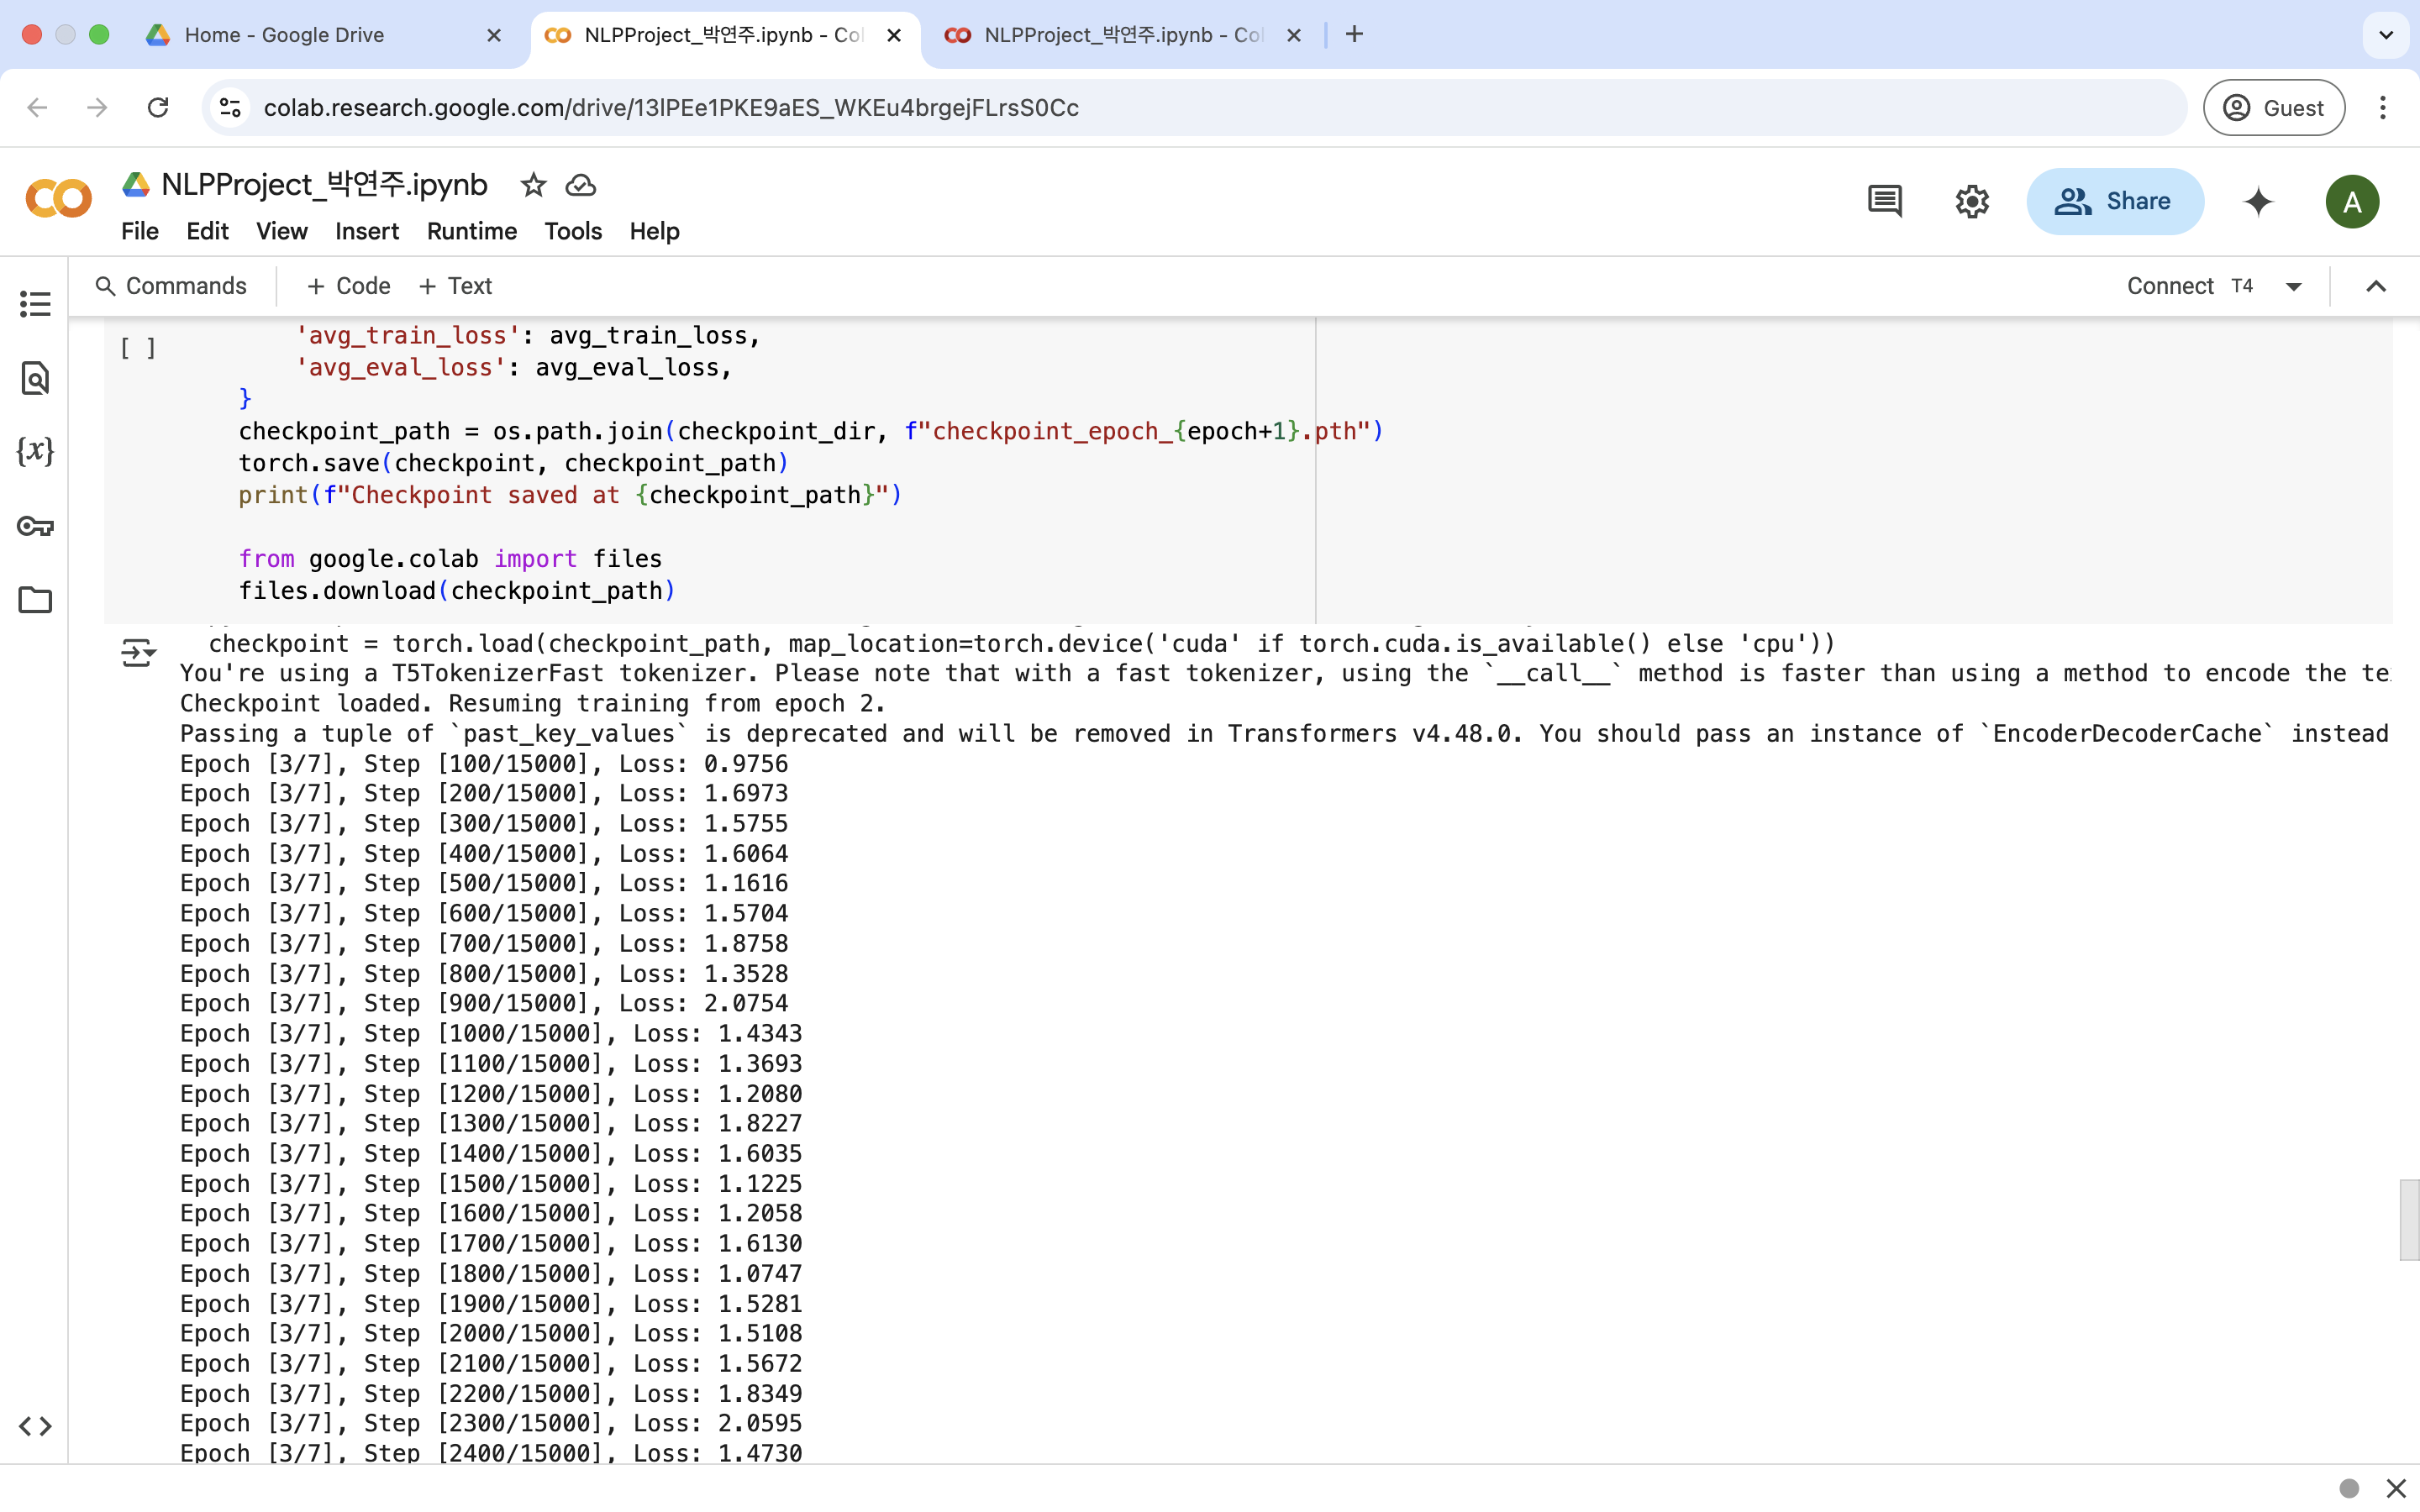

In [35]:
from IPython.display import Image, display
display(Image(filename='/Users/aria/Desktop/Screenshot 2025-03-09 at 23.34.44.png'))


In [31]:
import os
checkpoint_path = "/Users/aria/Downloads/checkpoint_epoch_2.pth"



# 체크포인트가 존재하면 불러오기
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # 저장된 epoch 이후부터 학습 이어갈 수 있음
    avg_train_loss = checkpoint['avg_train_loss']
    avg_eval_loss = checkpoint['avg_eval_loss']
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")


Checkpoint loaded. Resuming training from epoch 2.


In [36]:
import evaluate

model = model.to("cpu")
batch = {k: v.to("cpu") for k, v in batch.items()}

bleu_metric = evaluate.load("sacrebleu")

model.eval()
sample_size = 100
pred_texts = []
ref_texts = []

with torch.no_grad():
    for idx, batch in enumerate(eval_dataloader):
        # 루프 내에서 각 배치를 CPU로 변환
        batch = {k: v.to("cpu") for k, v in batch.items()}
        
        outputs = model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            max_length=64,
            num_beams=4
        )
        # 디코딩
        for pred_ids, label_ids in zip(outputs, batch["labels"]):
            pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)
            ref_text = tokenizer.decode(label_ids, skip_special_tokens=True)
            
            pred_texts.append(pred_text)
            # sacrebleu는 각 레퍼런스를 리스트로 감싸야 함
            ref_texts.append([ref_text])
        
        if (idx + 1)*eval_batch_size >= sample_size:
            break


bleu_score = bleu_metric.compute(predictions=pred_texts, references=ref_texts)
print("SacreBLEU:", bleu_score["score"])


SacreBLEU: 21.905223303403556


In [37]:
# inference 평가는 cpu에서 진행한 관계로 위 cell과 마찬가지로 cpu로 명시하여 옮긴 후 진행
device = torch.device("cpu")
model = model.to(device)
model.eval()  # 평가 모드

sentences = [
    "모든 액체, 젤, 에어로졸 등은 1커트짜리 여닫이 투명봉지 하나에 넣어야 합니다.",
    "미안하지만, 뒷쪽 아이들의 떠드는 소리가 커서, 광화문으로 가고 싶은데 표를 바꾸어 주시겠어요?",
    "은행이 너무 멀어서 안되겠네요. 현찰이 필요하면 돈을 훔치세요",
    "아무래도 분실한 것 같으니 분실 신고서를 작성해야 하겠습니다. 사무실로 같이 가실까요?",
    "부산에서 코로나 확진자가 급증해서 병상이 부족해지자 확진자 20명을 대구로 이송한다",
    "변기가 막혔습니다",
    "그 바지 좀 보여주십시오. 이거 얼마에 살 수 있는 것 입니까?",
    "비가 와서 백화점으로 가지 말고 두타로 갔으면 좋겠습니다.",
    "속이 안좋을 때는 죽이나 미음으로 아침을 대신합니다",
    "문대통령은 집단 이익에서 벗어나라고 말했다",
    "이것 좀 먹어 볼 몇 일 간의 시간을 주세요",
    "이 날 개미군단은 외인의 물량을 모두 받아 내었다",
    "통합 우승의 목표를 달성한 NC 다이노스 나성범이 메이저리그 진출이라는 또 다른 꿈을 향해 나아간다",
    "이번 구조 조정이 제품을 효과적으로 개발 하고 판매 하기 위한 회사의 능력 강화 조처임을 이해해 주시리라 생각합니다",
    "요즘 이 프로그램 녹화하며 많은 걸 느낀다"
]

for i, sentence in enumerate(sentences, 1):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=64,
            num_beams=4
        )
    
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    print(f"[Sentence {i}] {sentence}")
    print(f" -> Generated: {generated_text}\n")




[Sentence 1] 모든 액체, 젤, 에어로졸 등은 1커트짜리 여닫이 투명봉지 하나에 넣어야 합니다.
 -> Generated: 큐브.

[Sentence 2] 미안하지만, 뒷쪽 아이들의 떠드는 소리가 커서, 광화문으로 가고 싶은데 표를 바꾸어 주시겠어요?
 -> Generated: 큐브, I'm sorry, I'm sorry I'm so I'm going to go to Daeong, I'm going to go to the KKK I'm going to go to the KKKK, I'm going to go to Daeong, I'

[Sentence 3] 은행이 너무 멀어서 안되겠네요. 현찰이 필요하면 돈을 훔치세요
 -> Generated: 큐브 I can't get a cash if the bank is too far, so you can't get a cash. If you need a cash, you don't get a cash.

[Sentence 4] 아무래도 분실한 것 같으니 분실 신고서를 작성해야 하겠습니다. 사무실로 같이 가실까요?
 -> Generated: Panther, I'd I I I'd have to write a claim for the theft, as I think it's a theft, so I'd have to write a report for the theft. I'm going to write a report on the accident. I'm going to go to the office.

[Sentence 5] 부산에서 코로나 확진자가 급증해서 병상이 부족해지자 확진자 20명을 대구로 이송한다
 -> Generated: 큐브 is transferred to Da Dae-Dong, as the number of the severing people in the In the Busan, when the number of  ss of the  severed in Dae-Dong, as the number o